<a id='sect0'></a>
## <font color='darkblue'>Preface</font>
([article source](https://machinelearningmastery.com/growing-and-pruning-ensembles-in-python/)) <font size='3ptx'>**Ensemble member selection refers to algorithms that optimize the composition of an ensemble.**</font>

This may involve growing an ensemble from available models or pruning members from a fully defined ensemble.

The goal is often to reduce the model or computational complexity of an ensemble with little or no effect on the performance of an ensemble, and in some cases find a combination of ensemble members that results in better performance than blindly using all contributing models directly.

**In this tutorial, you will discover how to develop ensemble selection algorithms from scratch.**

After completing this tutorial, you will know:
* Ensemble selection involves choosing a subset of ensemble members that results in lower complexity than using all members and sometimes better performance.
* How to develop and evaluate a greedy ensemble pruning algorithm for classification.
* How to develop and evaluate an algorithm for greedily growing an ensemble from scratch.

### <font color='darkgreen'>Tutorial Overview</font>
This tutorial is divided into four parts; they are:
* <font size='3ptx'>[**Ensemble Member Selection**](#sect1)</font>
* <font size='3ptx'>[**Baseline Models and Voting**](#sect2)</font>
* <font size='3ptx'>[**Ensemble Pruning Example**](#sect3)</font>
* <font size='3ptx'>[**Ensemble Growing Example**](#sect4)</font>

In [13]:
from sklearn.datasets import make_classification
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import VotingClassifier
from matplotlib import pyplot as plt

<a id='sect1'></a>
## <font color='darkblue'>Ensemble Member Selection</font>
<font size='3ptx'>**[Voting](https://machinelearningmastery.com/voting-ensembles-with-python/) and [stacking](https://machinelearningmastery.com/stacking-ensemble-machine-learning-with-python/) ensembles typically combine the predictions from a heterogeneous group of model types.**</font>

Although the ensemble may have a large number of ensemble members, it is hard to know that the best combination of members is being used by the ensemble. For example, **instead of simply using all members, it is possible that better results could be achieved by adding one more different model type or removing one or more models**.

This can be addressed using a weighted average ensemble and using an optimization algorithm to find an appropriate weighting for each member, allowing some members to have a zero weight, which effectively removes them from the ensemble. <font color='darkred'>**The problem with a weighted average ensemble is that all models remain part of the ensemble, perhaps requiring an ensemble of greater complexity than is required to be developed and maintained.**</font>

**An alternative approach is to optimize the composition of the ensemble itself**. The general approach of automatically choosing or optimizing the members of ensembles is referred to as ensemble selection.

Two common approaches include <font color='darkblue'>**ensemble growing**</font> and <font color='darkblue'>**ensemble pruning**</font>:
* **Ensemble Growing:** Add members to the ensemble until no further improvement is observed.
* **Ensemble Pruning:** Remove members from the ensemble until no further improvement is observed.

**<font color='darkblue'>Ensemble growing</font> is a technique where the model starts with no members and involves adding new members until no further improvement is observed.** This could be performed in a greedy manner where members are added one at a time only if they result in an improvement in model performance.

**<font color='darkblue'>Ensemble pruning</font> is a technique where the model starts with all possible members that are being considered and removes members from the ensemble until no further improvement is observed.** This could be performed in a greedy manner where members are removed one at a time and only if their removal results in a lift in the performance of the overall ensemble.
> Given a set of trained individual learners, rather than combining all of them, ensemble pruning tries to select a subset of individual learners to comprise the ensemble. <br/><br/>
> [**— Page 119, Ensemble Methods: Foundations and Algorithms, 2012.**](https://amzn.to/2TavTcy)

**An advantage of ensemble pruning and growing is that it may result in an ensemble with a smaller size** (<font color='brown'>lower complexity</font>) **and/or an ensemble with better predictive performance**. Sometimes a small drop in performance is desirable if it can be achieved in a large drop in model complexity and resulting maintenance burden. Alternately, on some projects, predictive skill is more important than all other concerns, and ensemble selection provides one more strategy to try and get the most out of the contributing models.
> There are two main reasons for reducing the ensemble size: a) Reducing computational overhead: Smaller ensembles require less computational overhead and b) Improving Accuracy: Some members in the ensemble may reduce the predictive performance of the whole. <br/><br/>
> [**— Page 119, Pattern Classification Using Ensemble Methods, 2010.**](https://amzn.to/2zxc0F7)

Ensemble growing might be preferred for computational efficiency reasons in cases where a small number of ensemble members are expected to perform better, whereas ensemble pruning would be more efficient in cases where a large number of ensemble members may be expected to perform better.

Simple greedy ensemble growing and pruning have a lot in common with stepwise feature selection techniques, such as those used in regression (<font color='brown'>e.g. so-called stepwise regression</font>).

More sophisticated techniques may be used, such as selecting members for addition to or removal from the ensemble based on their standalone performance on the dataset, or even through the use of a global search procedure that attempts to find a combination of ensemble members that results in the best overall performance.
> … one can perform a heuristic search in the space of the possible different ensemble subsets while evaluating the collective merit of a candidate subset. <br/><br/>
> [**— Page 123, Pattern Classification Using Ensemble Methods, 2010.**](https://amzn.to/2zxc0F7)

Now that we are familiar with ensemble selection methods, let’s explore how we might implement ensemble pruning and ensemble growing in scikit-learn.

<a id='sect2'></a>
## <font color='darkblue'>Baseline Models and Voting</font>
<font size='3ptx'>**Before we dive into developing growing and pruning ensembles, let’s first establish a dataset and baseline.**</font>

We will use a synthetic binary classification problem as the basis for this investigation, defined by the [make_classification() function](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html) with **5,000 examples and 20 numerical input features.**

In [3]:
# test classification dataset

# define dataset
X, y = make_classification(n_samples=5000, n_features=20, n_informative=10, n_redundant=10, random_state=1)

# summarize the dataset
print(X.shape, y.shape)

(5000, 20) (5000,)


Next, we can choose some candidate models that will provide the basis for our ensemble.

We will use five standard machine learning models, including logistic regression ([**LogisticRegression**](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)), naive Bayes ([**GaussianNB**](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html#sklearn.naive_bayes.GaussianNB)), decision tree ([**DecisionTreeClassifier**](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#)), support vector machine ([**SVC**](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)), and a k-nearest neighbor algorithm ([**KNeighborsClassifier**](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)).

First, we can define a function that will create each model with default hyperparameters. Each model will be defined as a tuple with a name and the model object, then added to a list. This is a helpful structure both for enumerating the models with their names for standalone evaluation and for later use in an ensemble.

The <font color='blue'>get_models()</font> function below implements this and returns the list of models to consider.

In [5]:
# get a list of models to evaluate
def get_models():
    models = list()
    models.append(('lr', LogisticRegression()))
    models.append(('knn', KNeighborsClassifier()))
    models.append(('tree', DecisionTreeClassifier()))
    models.append(('nb', GaussianNB()))
    models.append(('svm', SVC(probability=True)))
    return models

We can then define a function that takes a single model and the dataset and evaluates the performance of the model on the dataset. We will evaluate a model using [repeated stratified k-fold cross-validation](https://machinelearningmastery.com/repeated-k-fold-cross-validation-with-python/) with 10 folds and three repeats, a good practice in machine learning.

The <font color='blue'>evaluate_model()</font> function below implements this and returns a list of scores across all folds and repeats.

In [6]:
# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
    # define the model evaluation procedure
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

    # evaluate the model
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    return scores

We can then create the list of models and enumerate them, reporting the performance of each on the synthetic dataset in turn.

In [10]:
# get the models to evaluate
models = get_models()

# evaluate the models and store results
results, names = list(), list()

for name, model in models:
    # evaluate model
    scores = evaluate_model(model, X, y)
    
    # store results
    results.append(scores)
    names.append(name)
    
    # summarize result
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))

>lr 0.856 (0.014)
>knn 0.953 (0.008)
>tree 0.865 (0.016)
>nb 0.847 (0.021)
>svm 0.953 (0.010)


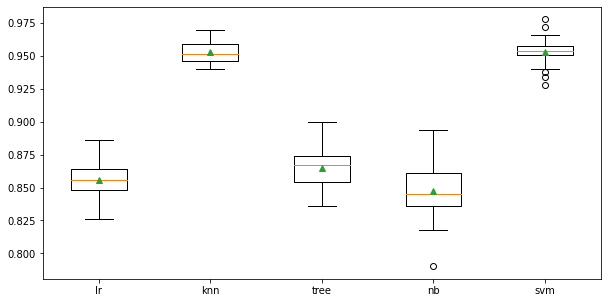

In [11]:
# plot model performance for comparison
plt.rcParams['figure.figsize'] = [10, 5]
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

**Next, we need to establish a baseline ensemble that uses all models**. This will provide a point of comparison with growing and pruning methods that seek better performance with a smaller subset of models.

In this case, we will use a [**voting ensemble**](https://machinelearningmastery.com/voting-ensembles-with-python/) with soft voting. This means that each model will predict probabilities and the probabilities will be summed by the ensemble model to choose a final output prediction for each input sample.

This can be achieved using the [**VotingClassifier**](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html) class where the members are set via the “<font color='violet'>estimators</font>” argument, which expects a list of models where each model is a tuple with a name and configured model object, just as we defined in the previous section.

We can then set the type of voting to perform via the “voting” argument, which in this case is set to “<font color='violet'>soft</font>”.

In [15]:
# create the ensemble
ensemble = VotingClassifier(estimators=models, voting='soft')

# define the evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# evaluate the ensemble
scores = cross_val_score(ensemble, X, y, scoring='accuracy', cv=cv, n_jobs=-1)

# summarize the result
print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean Accuracy: 0.930 (0.012)


In this case, we can see that the **voting ensemble achieved a mean accuracy of about 93.0 percent. This is lower than SVM and KNN models used alone that achieved an accuracy of about 95.3 percent.**

<font color='darkred'>**This result highlights that a simple voting ensemble of all models results in a model with higher complexity and worse performance in this case**</font>. Perhaps we can find a subset of members that performs better than any single model and has lower complexity than simply using all models.

<a id='sect3'></a>
## <font color='darkblue'>Ensemble Pruning Example</font> ([back](#sect0))
<font size='3ptx'>**In this section, we will explore how to develop a greedy ensemble pruning algorithm from scratch.**</font>

We will use a greedy algorithm in this case, which is straightforward to implement. This involves removing one member from the ensemble and evaluating the performance and repeating this for each member in the ensemble. The member that, if removed, results in the best improvement in performance is then permanently removed from the ensemble and the process repeats. This continues until no further improvements can be achieved.

**It is referred to as a “greedy” algorithm because it seeks the best improvement at each step. It is possible that the best combination of members is not on the path of greedy improvements**, in which case the greedy algorithm will not find it and a global optimization algorithm could be used instead.

First, we can define a function to evaluate a candidate list of models. This function will take the list of models and the dataset and construct a voting ensemble from the list of models and evaluate its performance using [repeated stratified k-fold cross-validation](https://machinelearningmastery.com/repeated-k-fold-cross-validation-with-python/), returning the mean classification accuracy.

This function can be used to evaluate each candidate’s removal from the ensemble. The <font color='blue'>evaluate_ensemble()</font> function below implements this.

In [16]:
# evaluate a list of models
def evaluate_ensemble(models, X, y):
    # check for no models    
    if len(models) == 0:
        return 0.0
    
    # create the ensemble
    ensemble = VotingClassifier(estimators=models, voting='soft')
    
    # define the evaluation procedure
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    
    # evaluate the ensemble
    scores = cross_val_score(ensemble, X, y, scoring='accuracy', cv=cv, n_jobs=-1)

    # return mean score
    return mean(scores)

Next, we can define a function that performs a single round of pruning.

First, a baseline in performance is established with all models that are currently in the ensemble. Then the list of models is enumerated and each is removed in turn, and the effect of removing the model is evaluated on the ensemble. **If the removal results in an improvement in performance, the new score and specific model that was removed is recorded.**

Importantly, the trial removal is performed on a copy of the list of models, not on the main list of models itself. This is to ensure we only remove an ensemble member from the list once we know it will result in the best possible improvement from all the members that could potentially be removed at the current step.

The <font color='blue'>prune_round()</font> function below implements this given the list of current models in the ensemble and dataset, and returns the improvement in score (<font color='brown'>if any</font>) and the best model to remove to achieve that score.

In [17]:
# perform a single round of pruning the ensemble
def prune_round(models_in, X, y):
    # establish a baseline
    baseline = evaluate_ensemble(models_in, X, y)
    best_score, removed = baseline, None
    # enumerate removing each candidate and see if we can improve performance
    for mi in range(len(models_in)):
        # model to be removed
        m = models_in[mi]
        
        # evaluate new ensemble
        result = evaluate_ensemble(models_in[:mi] + models_in[mi+1:], X, y)

        # check for new best
        if result > best_score:
            # store the new best
            best_score, removed = result, m

    return best_score, removed

Next, we need to drive the pruning process.

This involves running a round of pruning until no further improvement in accuracy is achieved by calling the <font color='blue'>prune_round()</font> function repeatedly.

If the function returns None for the model to be removed, we know that no single greedy improvement is possible and we can return the final list of models. Otherwise, the chosen model is removed from the ensemble and the process continues.

The <font color='blue'>prune_ensemble()</font> function below implements this and returns the models to use in the final ensemble and the score that it achieved via our evaluation procedure.

In [18]:
# prune an ensemble from scratch
def prune_ensemble(models, X, y):
    best_score = 0.0
    # prune ensemble until no further improvement
    while True:
        # remove one model to the ensemble
        score, removed = prune_round(models, X, y)

        # check for no improvement
        if removed is None:
            print('>no further improvement')
            break

        # keep track of best score
        best_score = score

        # remove model from the list
        models.remove(removed)

        # report results along the way
        print('>%.3f (removed: %s)' % (score, removed[0]))
        
    return best_score, models

Let's check how `ensemble pruning` goes:

In [19]:
%%time
# get the models to evaluate
models = get_models()

# prune the ensemble
score, model_list = prune_ensemble(models, X, y)
names = ','.join([n for n,_ in model_list])
print('Models: %s' % names)
print('Final Mean Accuracy: %.3f' % score)

>0.940 (removed: nb)
>0.949 (removed: tree)
>0.956 (removed: lr)
>no further improvement
Models: knn,svm
Final Mean Accuracy: 0.956


In this case, we can see that three rounds of pruning were performed, **removing the naive Bayes, decision tree, and logistic regression algorithms, leaving only the SVM and KNN algorithms that achieved a mean classification accuracy of about 95.6 percent. This is better than the 95.3 percent achieved by SVM and KNN used in a standalone manner**, and clearly better than combining all models together.

<a id='sect4'></a>
## <font color='darkblue'>Ensemble Growing Example</font> ([back](#sect0))
<font size='3ptx'>**In this section, we will explore how to develop a greedy ensemble growing algorithm from scratch.**</font>

The structure of greedily growing an ensemble is much like the greedy pruning of members, although in reverse. We start with an ensemble with no models and add a single model that has the best performance. Models are then added one by one only if they result in a lift in performance over the ensemble before the model was added.

**Much of the code is the same as the pruning case so we can focus on the differences.**

First, we must define a function to perform one round of growing the ensemble. This involves enumerating all candidate models that could be added and evaluating the effect of adding each in turn to the ensemble. The single model that results in the biggest improvement is then returned by the function, along with its score.

The <font color='blue'>grow_round()</font> function below implements this behavior.

In [21]:
# perform a single round of growing the ensemble
def grow_round(models_in, models_candidate, X, y):
    # establish a baseline
    baseline = evaluate_ensemble(models_in, X, y)
    best_score, addition = baseline, None
    
    # enumerate adding each candidate and see if we can improve performance
    for mi in range(len(models_candidate)):
        # model to be evaluated by adding into ensemble
        m = models_candidate[mi]
        
        # add the candidate
        dup = models_in.copy()
        dup.append(m)
        
        # evaluate new ensemble
        result = evaluate_ensemble(dup, X, y)
        
        # check for new best
        if result > best_score:
            # store the new best
            best_score, addition = result, m
            
    return best_score, addition

Next, we need a function to drive the growing procedure.

This involves a loop that runs rounds of growing until no further additions can be made resulting in an improvement in model performance. For each addition that can be made, the main list of models in the ensemble is updated and the list of models currently in the ensemble is reported along with the performance.

The <font color='blue'>grow_ensemble()</font> function implements this and returns the list of models greedily determined to result in the best performance along with the expected mean accuracy.

In [22]:
# grow an ensemble from scratch
def grow_ensemble(models, X, y):
    best_score, best_list = 0.0, list()
    
    # grow ensemble until no further improvement
    while True:
        # add one model to the ensemble
        score, addition = grow_round(best_list, models, X, y)
        
        # check for no improvement
        if addition is None:
            print('>no further improvement')
            break
            
        # keep track of best score
        best_score = score
        
        # remove new model from the list of candidates
        models.remove(addition)

        # add new model to the list of models in the ensemble
        best_list.append(addition)

        # report results along the way
        names = ','.join([n for n,_ in best_list])
        print('>%.3f (%s)' % (score, names))
        
    return best_score, best_list

Let's check how `ensemble growing` goes:

In [23]:
# get the models to evaluate
models = get_models()

# grow the ensemble
score, model_list = grow_ensemble(models, X, y)
names = ','.join([n for n,_ in model_list])
print('Models: %s' % names)
print('Final Mean Accuracy: %.3f' % score)

>0.953 (svm)
>0.956 (svm,knn)
>no further improvement
Models: svm,knn
Final Mean Accuracy: 0.956


In this case, we can see that **ensemble growing found the same solution as greedy ensemble pruning where an ensemble of SVM and KNN achieved a mean classification accuracy of about 95.6 percent, an improvement over any single standalone model and over combining all models**.